# Prepare 1000 Genome Reference dataset with full data

In [1]:
import allel
import h5py  # Python Package to do the HDF5.
import numpy as np
import pandas as pd
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.pyplot as plt

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
#sys.path.append("./Python3/")  # Since now we are in the Root Directory

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.insert(0,"./package/")  # hack to get local package first in path
from hapsburg.PackagesSupport.h5_python.h5_functions import merge_in_ld_map

midway2-0403.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Helper Function

In [2]:
def vcf_to_hdf5(in_path, out_path, path_vcf100g=""):
    """Transform Full VCF to full HDF5"""
    allel.vcf_to_hdf5(input=in_path, output=out_path, compression="gzip") # Takes 10 Minutes ####chunk_length=1000000, chunk_width=1, garbage performance
    
def download_1kg(path_source="", path_target=""):
    """cluster: Whether program is run on cluster"""
    tbi_s = path_source + ".tbi"
    tbi_t = path_target + ".tbi"
    
    !scp $path_source $path_target # Only Download the .vcf (not the .tbi)
    !scp $tbi_s $tbi_t             # Download the tbi
    print(f"Transfer complete. To {path_target}")

### Master Function

In [9]:
def full_prep_h5_full(ch = 4):
    """Function to run the full preparation of HDF from 1000G VCF. 
    Comment out steps if not needed."""
    ### The Paths
    path_vcf_source = f"/project2/jnovembre/data/external_public/1kg_phase3/haps/ALL.chr{ch}.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
    path_vcf_here = f"./Data/1000Genomes/AutosomeVCF/Full/chr{ch}.vcf.gz"
    path_h5 = f"./Data/1000Genomes/HDF5/FULLHDF5/chr{ch}_chunk.hdf5"
    
    path_snp1240k = "./Data/1000Genomes/Markers/MinMyc.snp"
    
    ### The functions of the pipeline
    #download_1kg(path_vcf_source, path_vcf_here)  ## Takes about 20 seconds
    #vcf_to_hdf5(path_vcf_here, path_h5)            ## Takes about 20 minutes
    merge_in_ld_map(path_h5=path_h5, path_snp1240k=path_snp1240k, chs=[ch,], write_mode="a")  ## Takes about XX seconds, mode a for new LD Map
    
    print(f"Run Successful!")

# Do the full Run

In [10]:
%%time
full_prep_h5_full(ch = 4)

Lifting LD Map from eigenstrat to HDF5...
Loaded 5732585 variants.
Loaded 2504 individuals.
Loaded 71634 Chr.4 1240K SNPs.
Intersection 69197 out of 5732585 HDF5 SNPs
Interpolating 5663388 variants.
Finished Chromosome 4.
Adding map to HDF5...
We did it. Finished.
Run Successful!
CPU times: user 12 s, sys: 619 ms, total: 12.6 s
Wall time: 19.1 s


# Todo: Set genotpe data to int8 (to save space when loading data into RAM) 

In [ ]:
%%time

out_folder = "./Data/1000Genomes/HDF5/1240kHDF5/all1240bool0/chr"

def create_int_h5(org_folder = "./Data/1000Genomes/HDF5/FULLHDF5/chr",
                  out_folder = "./Data/1000Genomes/HDF5/FULLHDF5.int8/chr",
                  ch=4):
    """Create a int8 genotype hdf5 from full hdf5"""
    load_path = org_folder + str(ch) + ".h5"
    save_path = out_folder + str(ch) + ".h5" 

    # Make Directory if not already there
    if not os.path.exists(os.path.dirname(save_path)):   
        os.makedirs(os.path.dirname(save_path))

    #os.remove(save_path)  # For previous whoopsie
    m = ModifyHDF5Genotypes(original_path=load_path, save_path=save_path)
    m.downsample_gt(frac=1.0, ad=False, mult_alt=True, gt_type="int8")

# Area 51

### Test loading the new hdf5 file

In [49]:
### Test the Final HDF5 just created
ch = 4
path_load = f"./Data/1000Genomes/HDF5/FULLHDF5/chr{ch}.hdf5"

f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded 5732585 variants
Loaded 2504 individuals
['GT']
['ALT', 'CHROM', 'FILTER_PASS', 'ID', 'MAP', 'POS', 'QUAL', 'REF']


# Do experiments about loading time of data

In [52]:
from time import time

In [53]:
%%time
res = []
s = np.shape(f["calldata/GT"])
ts = [10,50,100,500,1000, 5000, 10000, 50000, 100000]

for i in ts:
    print(f"Doing {i} Loci")
    t = time() 
    idx = np.random.randint(s[0], size=i)
    idx=  np.sort(idx)
    gt = f["calldata/GT"][idx,:,:]
    e = time()
    res.append(e-t)

Doing 10 Loci
Doing 50 Loci
Doing 100 Loci
Doing 500 Loci
Doing 1000 Loci
Doing 5000 Loci


TypeError: Indexing elements must be in increasing order

In [46]:
time = [10,50,100,500,1000]

In [45]:
f.close()

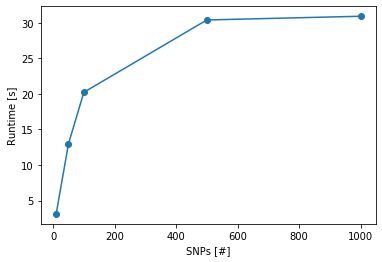

In [48]:
plt.figure()
ax = plt.gca()
ax.plot(ts, res, "o-")
ax.set_xlabel("SNPs [#]")
ax.set_ylabel("Runtime [s]")
plt.show()

In [38]:
np.shape(gt)

(100, 2504, 2)

### The super slow chunked HDF5

In [17]:
### Test the Final HDF5 just created
ch = 4
path_load = f"./Data/1000Genomes/HDF5/FULLHDF5/chr{ch}_chunk.hdf5"

f = h5py.File(path_load, "r") # Load for Sanity Check. See below!
print("Loaded %i variants" % np.shape(f["calldata/GT"])[0])
print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
print(list(f["calldata"].keys()))
print(list(f["variants"].keys()))

Loaded 5732585 variants
Loaded 2504 individuals
['GT']
['ALT', 'CHROM', 'FILTER_PASS', 'ID', 'MAP', 'POS', 'QUAL', 'REF']


# Do experiments with loading splits

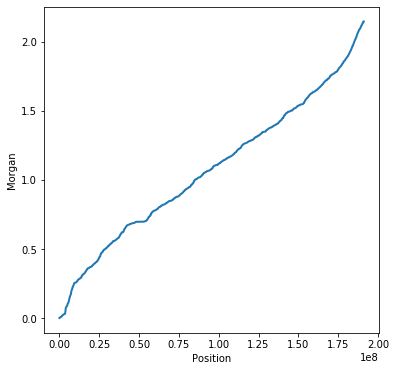

In [14]:
plt.figure(figsize=(6,6))
ax = plt.gca()

ax.plot(f["variants/POS"][:], f["variants/MAP"][:], lw=2)
ax.set_xlabel("Position")
ax.set_ylabel("Morgan")
plt.show()

In [10]:
np.shape(f["calldata/GT"])

(5732585, 2504, 2)

In [7]:
f["calldata/GT"][:100,0,0].

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [11]:
f.close()